In [4]:
import numpy as np
import geopandas
import rioxarray
import xarray as xr
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy.ma as ma
import datetime

In [5]:
dataset = xr.open_dataset("./italiaecmwf.nc", decode_coords="all")
shapefile = geopandas.read_file('./italy_shapefile/it_10km.shp', crs="epsg:4326")
dataset

<xarray.Dataset>
Dimensions:    (longitude: 15, latitude: 15, time: 248)
Coordinates:
  * longitude  (longitude) float32 7.0 7.75 8.5 9.25 ... 15.25 16.0 16.75 17.5
  * latitude   (latitude) float32 46.5 45.75 45.0 44.25 ... 37.5 36.75 36.0
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-01-31T21:00:00
Data variables: (12/20)
    aod1240    (time, latitude, longitude) float32 ...
    aod469     (time, latitude, longitude) float32 ...
    aod550     (time, latitude, longitude) float32 ...
    aod670     (time, latitude, longitude) float32 ...
    aod865     (time, latitude, longitude) float32 ...
    tcco       (time, latitude, longitude) float32 ...
    ...         ...
    tc_no      (time, latitude, longitude) float32 ...
    gtco3      (time, latitude, longitude) float32 ...
    tc_pan     (time, latitude, longitude) float32 ...
    tc_c3h8    (time, latitude, longitude) float32 ...
    tcso2      (time, latitude, longitude) float32 ...
    tcwv       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-14 11:11:22 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [9]:
dataset[['tcco']]

<xarray.DataArray 'tcco' (time: 248, latitude: 15, longitude: 15)>
[55800 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 7.0 7.75 8.5 9.25 ... 15.25 16.0 16.75 17.5
  * latitude   (latitude) float32 46.5 45.75 45.0 44.25 ... 37.5 36.75 36.0
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-01-31T21:00:00
Attributes:
    units:          kg m**-2
    long_name:      Total column Carbon monoxide
    standard_name:  atmosphere_mass_content_of_carbon_monoxide

In [11]:
dataset = dataset[['tcco', 'gtco3', 'tcno2']]
dataset.rio.write_crs("epsg:4326", inplace=True)
italy_dataset = dataset.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs, drop=True)

In [42]:
datarray_CO = dataset.tcco
datarray_CO.rio.write_crs("epsg:4326", inplace=True)
clipped = datarray_CO.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs, drop=True)

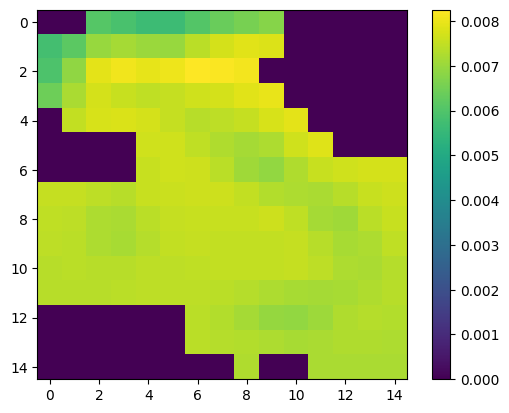

In [43]:
monthly_CO_Italy = (clipped.tcco.resample(time="1MS", restore_coord_dims=True).sum(dim='time'))/30
plt.imshow(monthly_CO_Italy[0])
plt.colorbar()

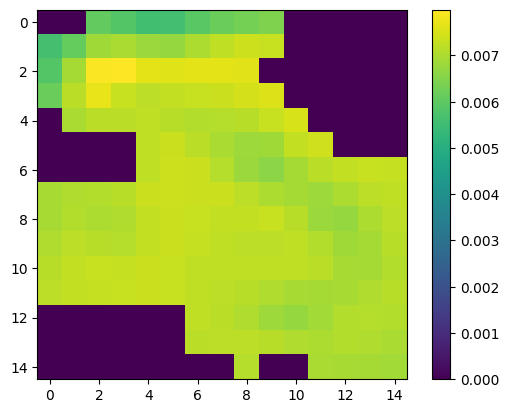

In [44]:
daily_CO_Italy = (clipped.resample(time="1D", restore_coord_dims=True).sum(dim='time'))
plt.imshow(daily_CO_Italy[0])
plt.colorbar()

In [45]:
daily_CO_Italy_vals = np.array(daily_CO_Italy)
italia=daily_CO_Italy_vals[daily_CO_Italy_vals!=0].size
vector=np.zeros([31,1])
j=0
while j<31:
    m=daily_CO_Italy_vals[j]
    vector[j]=sum(sum(m))/italia
    j=j+1

In [8]:
datarray_O3=dataset.gtco3
datarray_O3.rio.write_crs("epsg:4326", inplace=True)
clipped = datarray_O3.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs, drop=True)

daily_O3_Italy = (clipped.resample(time="1D", restore_coord_dims=True).sum(dim='time'))
daily_O3_Italy=np.array(daily_O3_Italy)
italia=daily_O3_Italy[daily_O3_Italy!=0].size
vector_O3=np.empty([31,1])
j=0
while j<31 :
    m=daily_O3_Italy[j]
    vector_O3[j]=sum(sum(m))/italia
    j=j+1

In [9]:
datarray_NO2=dataset.tcno2
datarray_NO2.rio.write_crs("epsg:4326", inplace=True)
clipped = datarray_NO2.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs, drop=True)

daily_NO2_Italy = (clipped.resample(time="1D", restore_coord_dims=True).sum(dim='time'))
daily_NO2_Italy=np.array(daily_NO2_Italy)
italia=daily_NO2_Italy[daily_NO2_Italy!=0].size
vector_NO2=np.empty([31,1])
j=0
while j<31:
    m=daily_NO2_Italy[j]
    vector_NO2[j]=sum(sum(m))/italia
    j=j+1

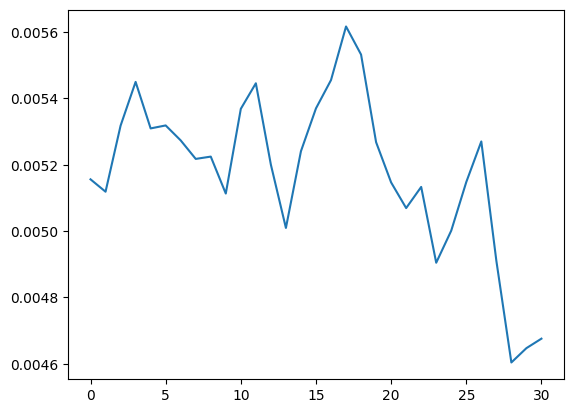

In [47]:
plt.plot(np.arange(0,31), daily_CO_Italy.groupby("time").mean(dim=['longitude', 'latitude']).values)

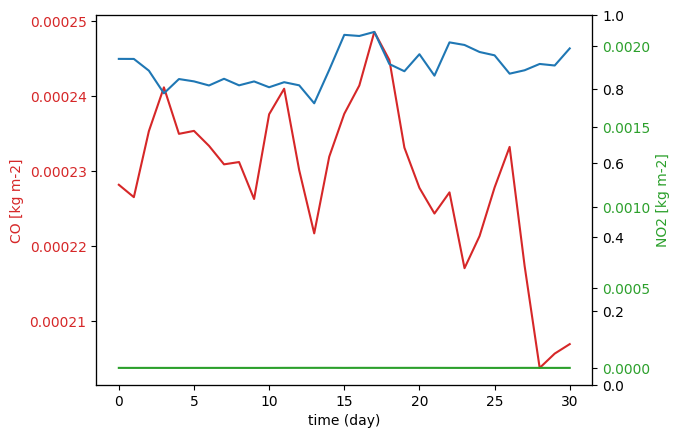

In [13]:
# Create some mock data
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (day)')
ax1.set_ylabel('CO [kg m-2]', color=color)
ax1.plot(time, vector, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('O3 [kg m-2]', color=color)  # we already handled the x-label with ax1
ax2.plot(time, vector_O3, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('NO2 [kg m-2]', color=color)  # we already handled the x-label with ax1
ax2.plot(time, vector_NO2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

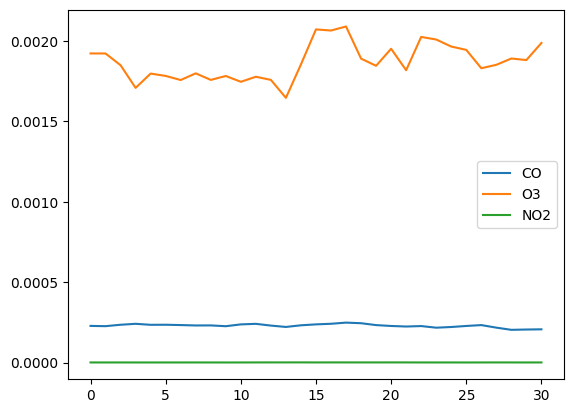

In [14]:
plt.plot(time, vector, label = "CO")
plt.plot(time, vector_O3, label = "O3")
plt.plot(time, vector_NO2, label = "NO2")
plt.legend()
plt.show()

In [15]:
datarray_O3=dataset.gtco3
daily_O3_Italy = (datarray_O3.resample(time="1D", restore_coord_dims=True).sum(dim='time'))
daily_O3_Italy=np.array(daily_O3_Italy)
daily_O3_Italy.shape
j=0
i=0
while j<31 :
    m=daily_O3_Italy[j]
    while i<18:
        vector[j,i]=sum(sum(daily_O3_Italy[j]))

KeyboardInterrupt: 

In [16]:
datarray_O3=dataset.gtco3
daily_O3_Italy = (datarray_O3.resample(time="1D", restore_coord_dims=True).sum(dim='time'))
daily_O3_Italy=np.array(daily_O3_Italy)
italia=daily_O3_Italy[daily_O3_Italy!=0].size


i=0 
j=0 
d=0 
col=daily_O3_Italy.shape[2] 
row=daily_O3_Italy.shape[1] 
numday=daily_O3_Italy.shape[0] 
dim=(row, numday) 
output=np.empty(dim)*0

In [17]:
datarray_O3=dataset.gtco3
daily_O3_Italy = (datarray_O3.resample(time="1D", restore_coord_dims=True).sum(dim='time'))
daily_O3_Italy=np.array(daily_O3_Italy)
italia=daily_O3_Italy[daily_O3_Italy!=0].size


i=0
d=0 
col=daily_O3_Italy.shape[2] 
row=daily_O3_Italy.shape[1] 
numday=daily_O3_Italy.shape[0] 
dim=(row, numday) 
output=np.empty(dim)*0

for d in range (0,numday,1): 
    for i in range (row):
        j=0
        for j in range (col): 
            output[i,d]=output[i,d]+daily_O3_Italy[d,i,j]
            j=j+1
        i=i+1
    d=d+1
    

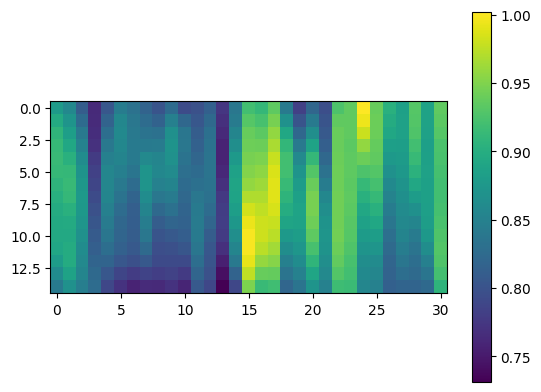

In [18]:
plt.imshow(output)
plt.colorbar()

In [19]:
i=0 
j=0 
d=0 
col=day.shape[2] 
row=day.shape[1] 
numday=day.shape[0] 
dim=(row,col) 
output=np.empty(dim)*0 
 
range_day_prova=(0,5) 
for i in range (row-1): 
    for j in range (col-1): 
        cont=0 
        for d in range (365,numday-1,1): 
            piove=0 
            if day[d,i,j]>0.0001: 
                piove=1 
             
            if piove==1: 
                cont=cont+1 
            else: 
                if cont>output[i,j]: 
                    output[i,j]=cont 
                cont=0 
             

NameError: name 'day' is not defined